In [84]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform, euclidean, seuclidean, sqeuclidean
import matplotlib.pyplot as plt
import networkx as nx
import collections

In [85]:
data = pd.read_csv("Data/ml-100k/u.data", sep = "\t", header = None, names = ["user_id", "item_id", "rating", "ts"])
users = pd.read_csv("Data/ml-100k/u.user", sep = "|", header = None, names = ["user_id", "age", "sex", "occupation", "ts"])
movies = pd.read_csv("Data/ml-100k/u.item", sep = "|", encoding="ISO-8859-1", header = None, names = ["item_id", "movie_title", "release_date", "3", "IMdb_url", "unknown",
"Action",
"Adventure",
"Animation",
"Children\'s",
"Comedy",
"Crime",
"Documentary",
"Drama",
"Fantasy",
"Film-Noir",
"Horror",
"Musical",
"Mystery",
"Romance",
"Sci-Fi",
"Thriller",
"War",
"Western"])

# reduce ids by 1 for easier indexing
users.user_id = users.user_id.apply(lambda x: x-1)
movies.item_id = movies.item_id.apply(lambda x: x-1)
data.user_id = data.user_id.apply(lambda x: x-1)
data.item_id = data.item_id.apply(lambda x: x-1)


In [86]:
ratings = np.zeros((943, 1682))
for i in range(data.shape[0]):
                   ratings[data.user_id[i], data.item_id[i]] = data.rating[i]

In [87]:
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

### Exploration


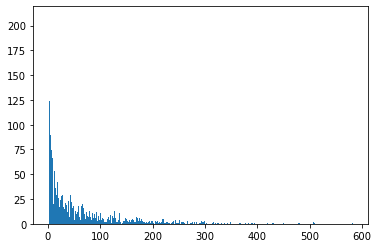

In [88]:
# Check number of reviews per movies
plt.hist((ratings != 0).sum(axis = 0), bins = 320)
plt.show()


We observe that a lot of movies have very few ratings. Since we want to provide a recommender system based on ratings we need to threshold the movies to make sure to have enough ratings. We want the movies to have a minimum of 5 ratings to be taken into consideration.


In [220]:
indices = ((ratings != 0).sum(axis = 0) >= 5)
old_indices = [i for i, x in enumerate(indices) if x]
new_indices = np.arange(np.sum(indices))
indices_map = zip(new_indices, old_indices)

ratings = ratings[:, indices]
ratings.shape

(943, 1349)

### Weights

To determine the distance between two nodes, whether they are movies or users, we choose to relate them with respect to their common ratings and how close to each other they are. The main issue we meet is the lack of common ground between movies or users. We need to decide whether we want to put more weight on how many movies two users have both seen, or how close their ratings. To do so, we compose the weights between two nodes in two parts:

* N = Number of 
* C = Cosine similarity between 
* E = Normalized euclidean distance between the ratings of movies that two users have both seen OR between the ratings common users have given a movie. This has a value between 0 and 1; 0 being the most similar.

In [95]:
'''Custom metric functions'''
def number_common(u, v) :
    return ((u != 0) & (v != 0)).sum()

def euclidean_distance_common(u, v) :
    # get common values
    mask = ((u != 0) & (v != 0))
    count = mask.sum()
    if (count == 0):
        return 5

    return np.sqrt(sqeuclidean(u[mask], v[mask]) / count)

In [104]:
'''Movie based distance matrices'''
# N
common_movies = squareform(pdist(ratings.T, metric = number_common))
common_movies -= np.diag(np.diag(common_movies))
common_movies = 1 - (common_movies - common_movies.min()) / (common_movies.max() - common_movies.min()) - np.eye(common_movies.shape[0])

#J
jaccard_similarity_movies = squareform(pdist(ratings.T, metric = 'cosine'))

#E
euclidean_distance_matrix_movies = squareform(pdist(ratings.T, metric = euclidean_distance_common))

In [98]:
'''User based distance matrices'''
# N
common_users = squareform(pdist(ratings, metric = number_common))
common_users -= np.diag(np.diag(common_users))
common_users = 1 - (common_users - common_users.min()) / (common_users.max() - common_users.min()) - np.eye(common_users.shape[0])

#J
jaccard_similarity_users = squareform(pdist(ratings, metric = 'cosine'))

#E
euclidean_distance_matrix_users = squareform(pdist(ratings, metric = euclidean_distance_common))

### Distances distribution visualization

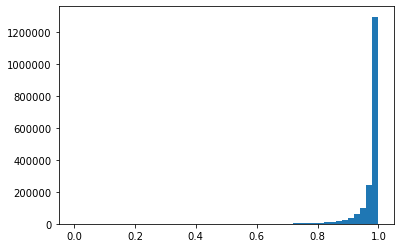

In [99]:
plt.hist(common_movies.flatten(), bins = 50)
plt.show()

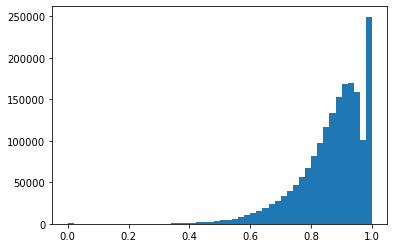

In [100]:
plt.hist(jaccard_similarity_movies.flatten(), bins = 50)
plt.show()

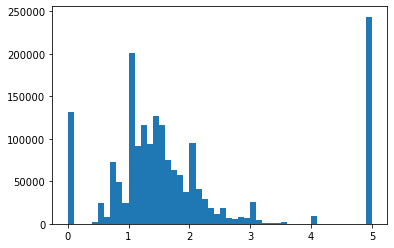

In [101]:
plt.hist(euclidean_distance_matrix_movies.flatten(), bins = 50)
plt.show()

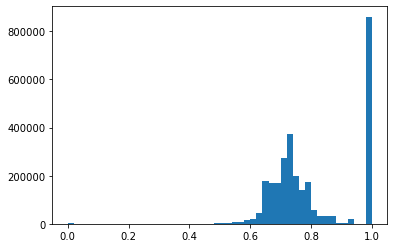

In [83]:
plt.hist((jaccard_similarity_movies.flatten() + euclidean_distance_matrix_movies.flatten() * 0.2 + common_movies.flatten()) / 3, bins = 50)
plt.show()

### Adjacency matrices

In [105]:
"""Given three distances matrices, build adjacency matrix with all nodes connected to at least one other node and with minimum average degree"""
def build_adjacency(d1, d2, d3):
    c1 = np.logspace(-2, 2, 5)
    c2 = np.logspace(-2, 2, 5)
    c3 = np.logspace(-2, 2, 5)
    #threshold = np.linspace(0.4, 0.6)
    params = []
    #adjacencies = []
    avg_degrees = []
    i = 0;
    min_degree = 1000
    for a in c1:
        for b in c2:
            for c in c3:
                print("iter: " + str(i))
                i += 1
                if (a+b+c == 0):
                    continue
                adjacency = (a * d1 + b * d2 + c * d3) / (a + b + c)
                adjacency = (1 - adjacency - np.eye(adjacency.shape[0])) * (adjacency < 0.5)
                if ((np.count_nonzero(adjacency.sum(axis=0) == 0) < 1)) :
                    #adjacencies.append(adjacency)

                    avg_degree = adjacency.sum(axis = 0).mean()
                    if (avg_degree < min_degree) :
                        min_degree = avg_degree
                        opt_adjacency = adjacency
                        print(avg_degree)
                        avg_degrees.append(avg_degree)
                        params.append((a, b, c))


    return opt_adjacency, params, avg_degrees


In [106]:
adjacency_movies, P, D = build_adjacency(jaccard_similarity_movies, euclidean_distance_matrix_movies * 0.2, common_movies)

iter: 0
iter: 1
iter: 2
iter: 3
iter: 4
iter: 5
656.5322766820085
iter: 6
iter: 7
iter: 8
iter: 9
iter: 10
iter: 11
iter: 12
iter: 13
iter: 14
iter: 15
iter: 16
iter: 17
iter: 18
52.01618877449855
iter: 19
iter: 20
iter: 21
iter: 22
iter: 23
iter: 24
iter: 25
iter: 26
iter: 27
iter: 28
iter: 29
iter: 30
iter: 31
iter: 32
iter: 33
iter: 34
iter: 35
iter: 36
iter: 37
iter: 38
iter: 39
iter: 40
iter: 41
iter: 42
iter: 43
iter: 44
iter: 45
iter: 46
iter: 47
iter: 48
iter: 49
iter: 50
iter: 51
iter: 52
iter: 53
iter: 54
iter: 55
iter: 56
iter: 57
iter: 58
iter: 59
iter: 60
iter: 61
iter: 62
iter: 63
iter: 64
iter: 65
iter: 66
iter: 67
iter: 68
iter: 69
iter: 70
iter: 71
iter: 72
iter: 73
iter: 74
iter: 75
iter: 76
iter: 77
iter: 78
iter: 79
iter: 80
iter: 81
iter: 82
iter: 83
iter: 84
iter: 85
iter: 86
iter: 87
iter: 88
iter: 89
iter: 90
iter: 91
iter: 92
iter: 93
iter: 94
iter: 95
iter: 96
iter: 97
iter: 98
iter: 99
iter: 100
iter: 101
iter: 102
iter: 103
iter: 104
iter: 105
iter: 106
iter

In [107]:
from pygsp import graphs, plotting, filters, utils


In [307]:
# mask = (adjacency_movies.sum(axis=0) != 0)

In [169]:
# G = graphs.Graph(adjacency_movies[mask][:, mask])
G = graphs.Graph(adjacency_movies)

In [170]:
G.compute_laplacian(lap_type='combinatorial')
G.compute_fourier_basis()

In [215]:
tau = 10
g = filters.Heat(G, tau)

In [213]:
signal = ratings[404]
# s = s[mask]

In [173]:
signal.shape

(1349,)

In [174]:
G.set_coordinates()

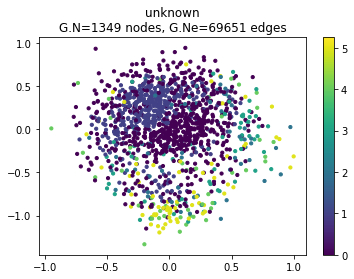

In [214]:
G.plot_signal(signal, vertex_size = 10)

In [200]:
def iterfilter(signal, g, N):
    s = signal
    for i in range(N):
        print("Iteration: " + str(i))
        s = g.filter(s, method = 'exact')
        s = rescale(np.min(s),5, s)
        indices = (signal != 0)
        s[indices] = signal[indices]
        G.plot_signal(s, vertex_size = 10)
    
    return s
    

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49


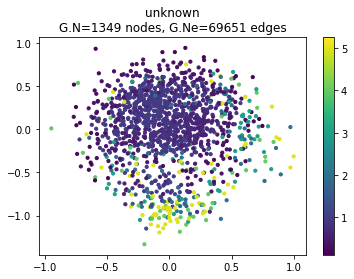

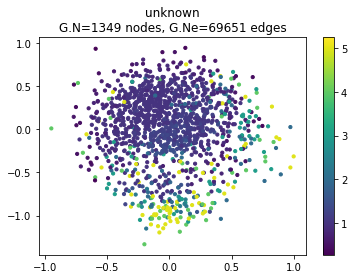

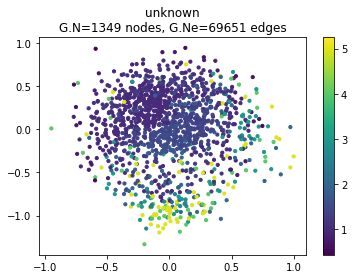

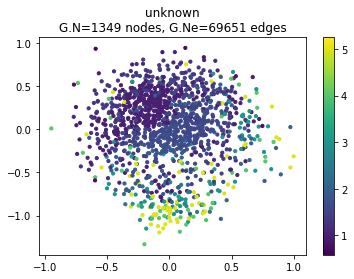

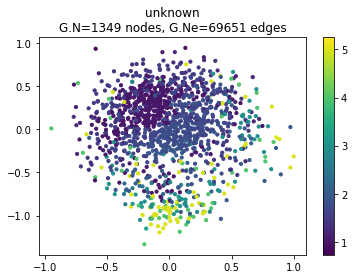

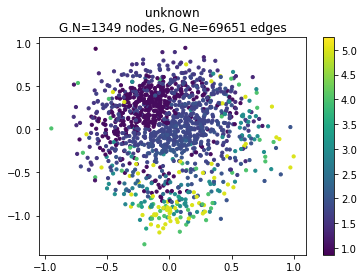

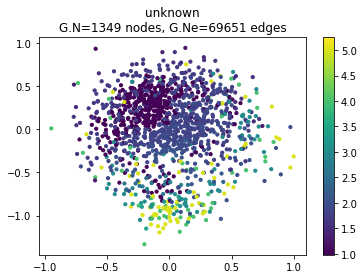

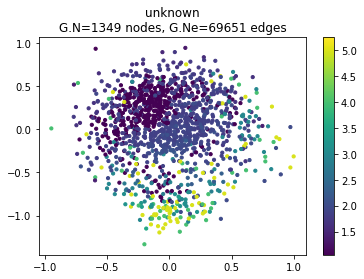

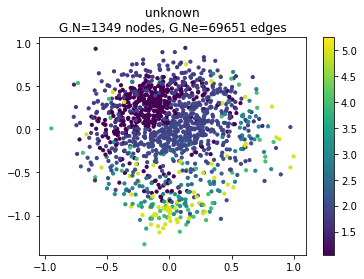

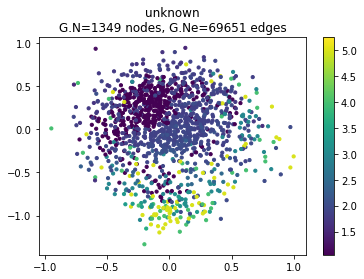

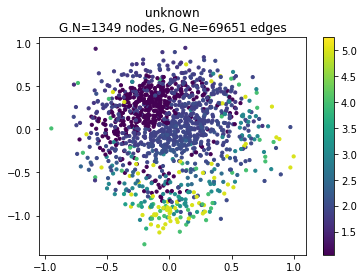

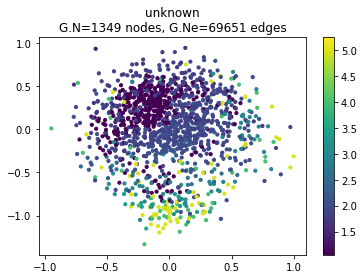

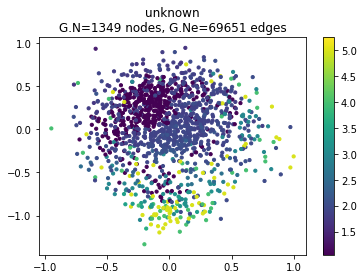

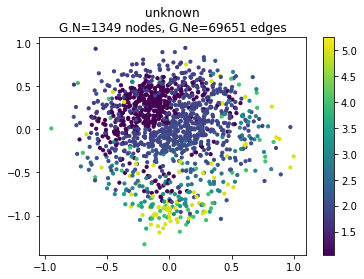

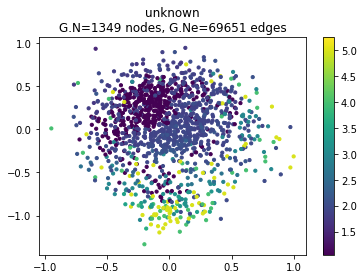

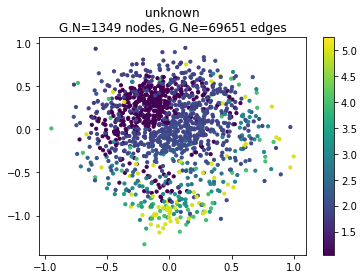

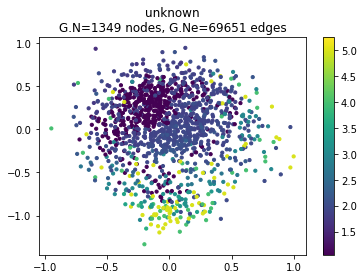

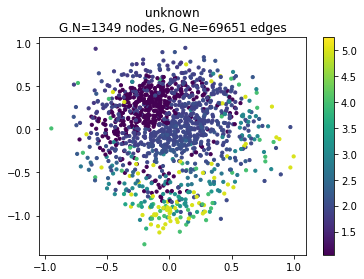

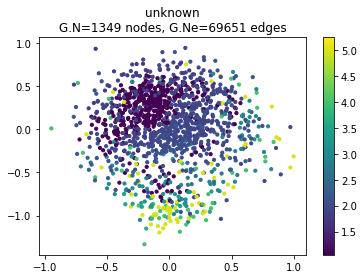

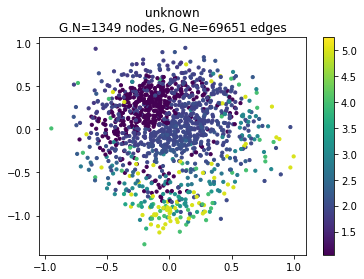

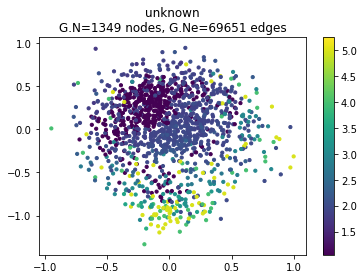

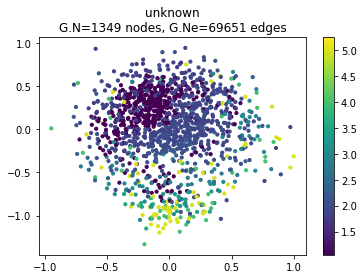

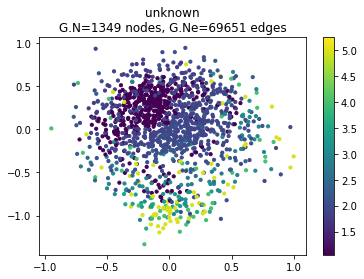

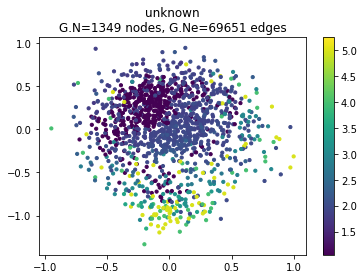

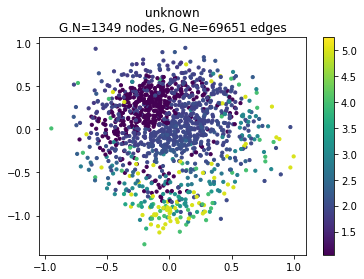

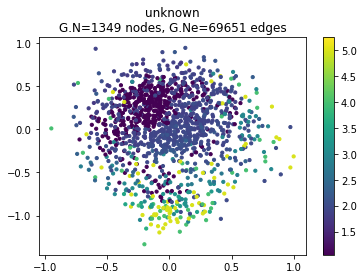

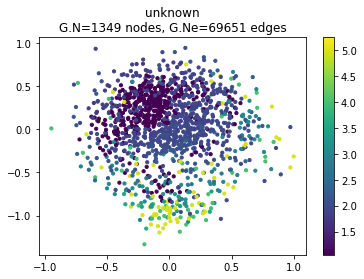

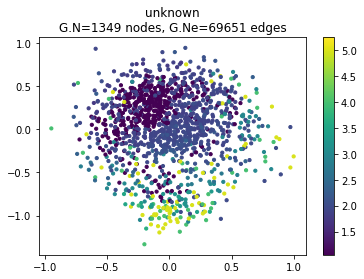

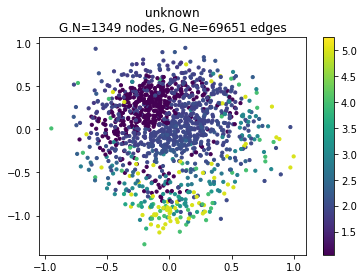

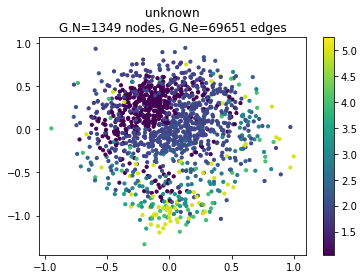

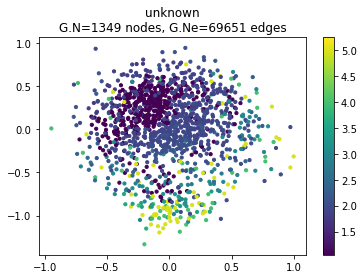

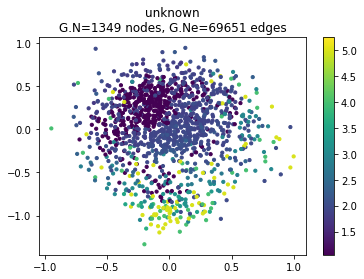

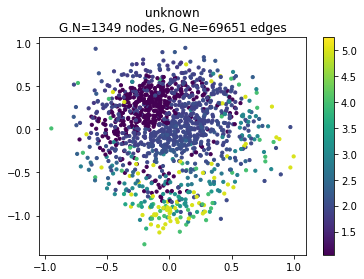

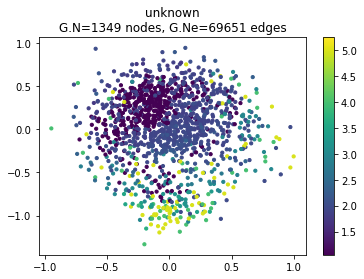

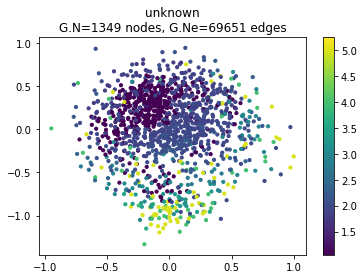

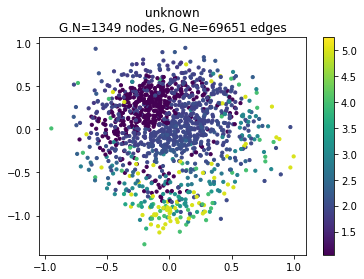

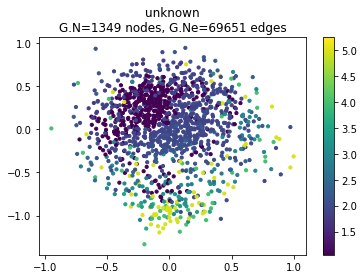

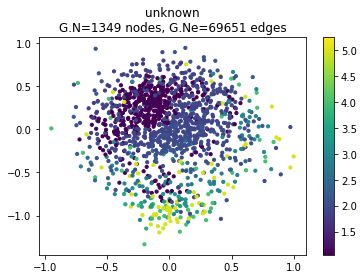

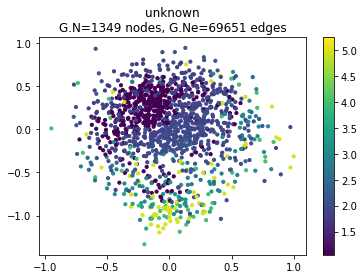

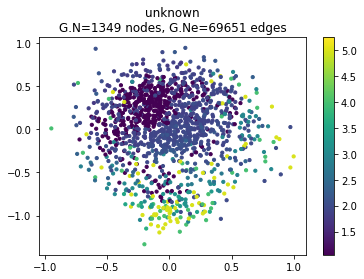

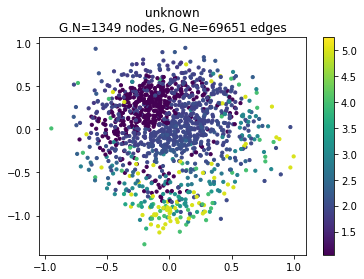

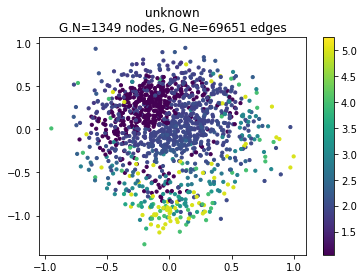

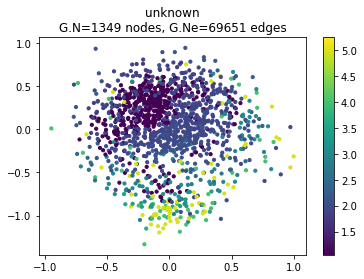

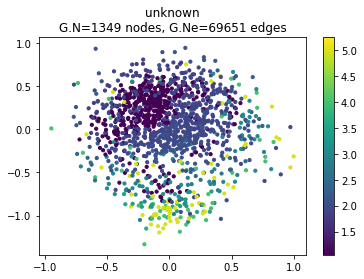

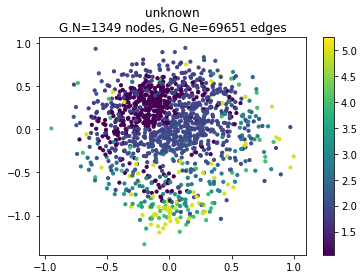

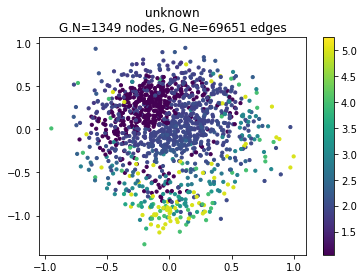

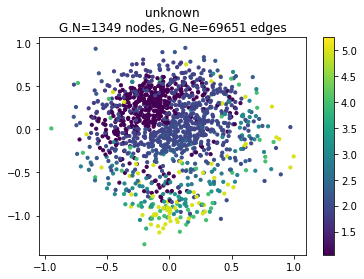

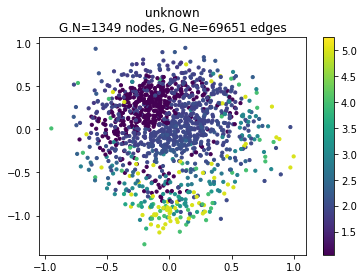

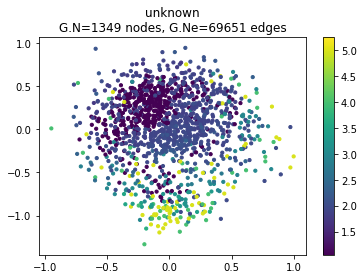

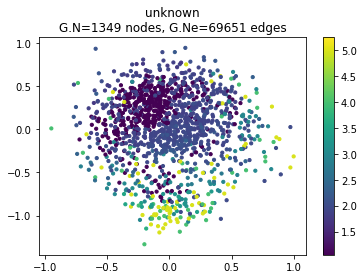

In [216]:
s = iterfilter(signal, g, 50)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21


C:\Users\Labhard\Anaconda3\envs\ntds_2019\lib\site-packages\pygsp\plotting.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49


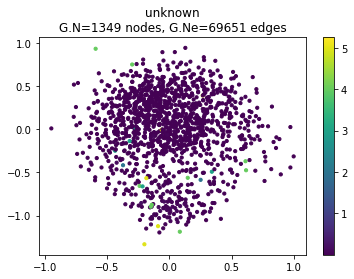

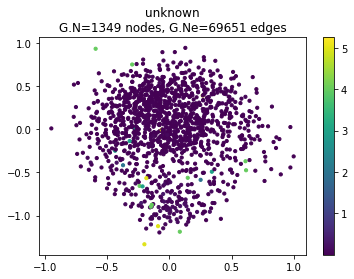

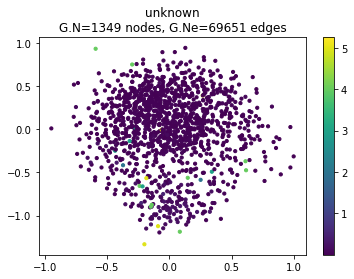

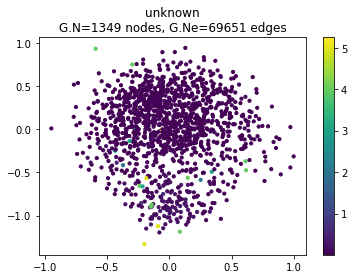

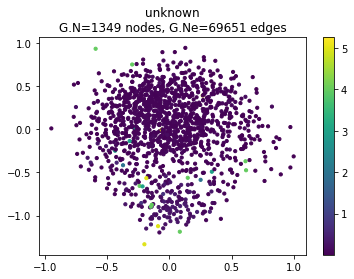

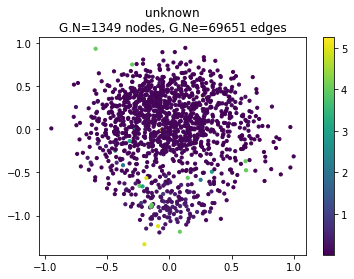

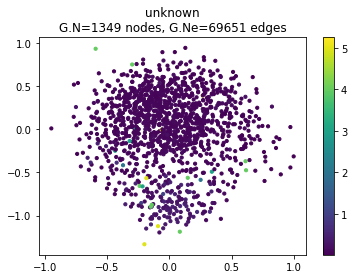

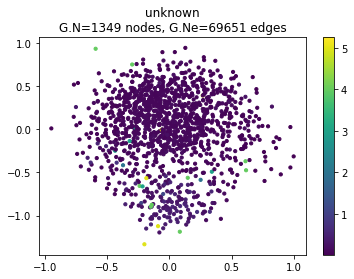

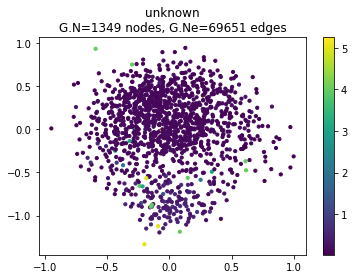

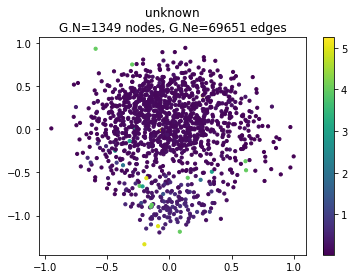

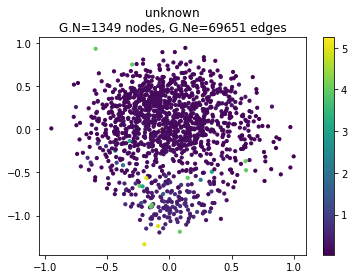

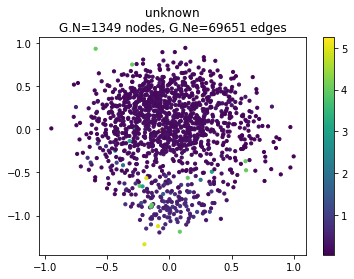

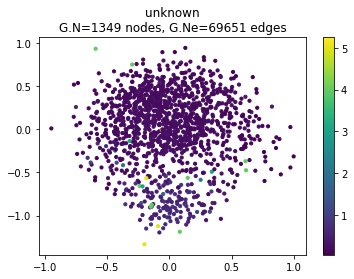

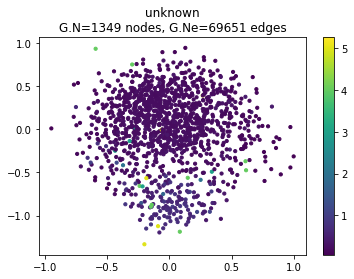

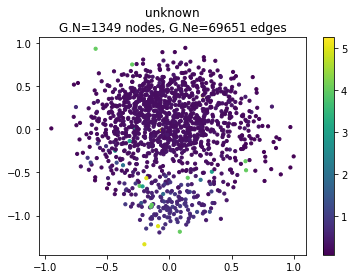

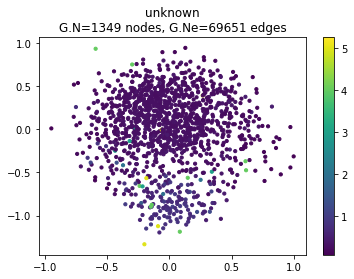

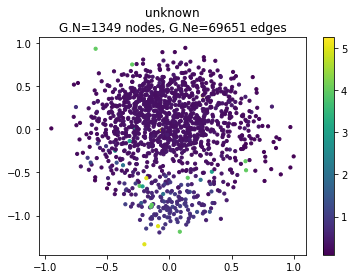

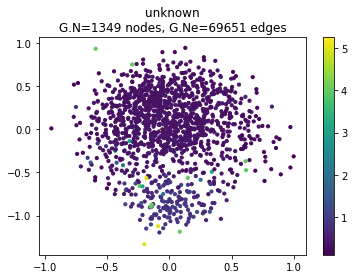

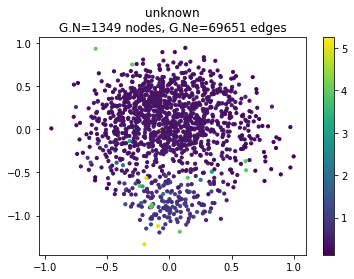

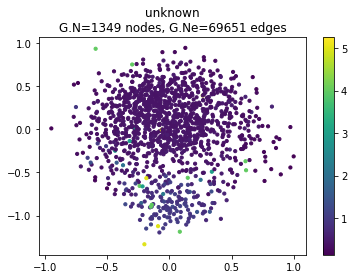

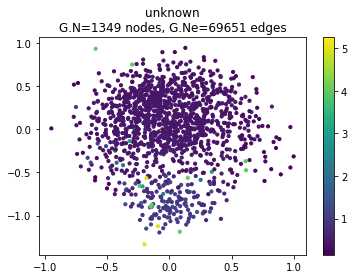

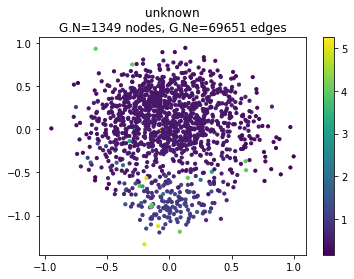

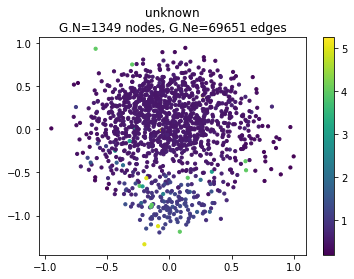

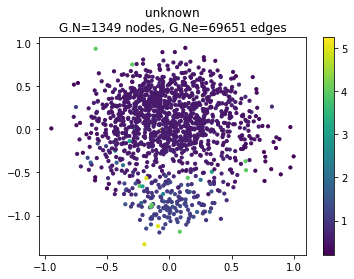

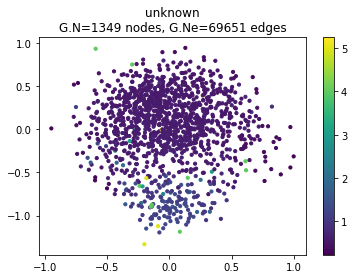

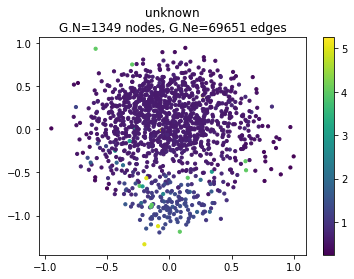

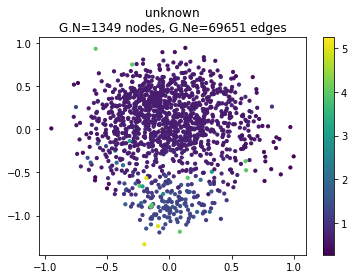

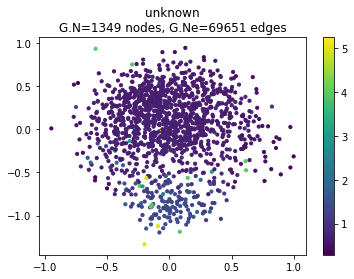

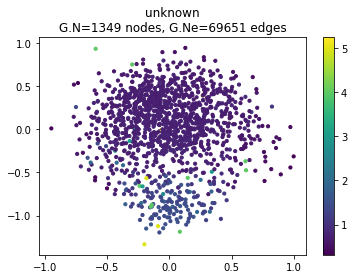

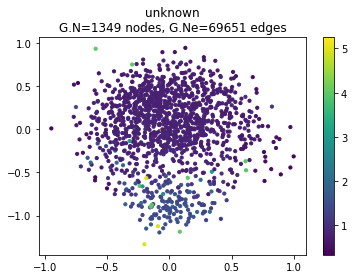

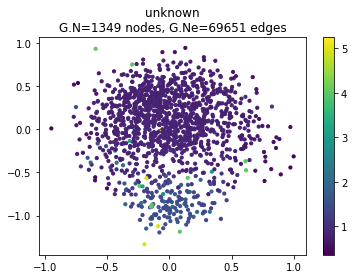

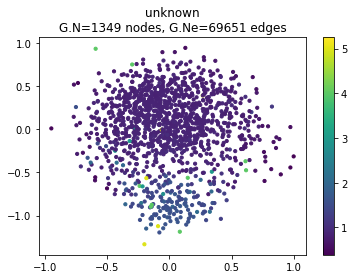

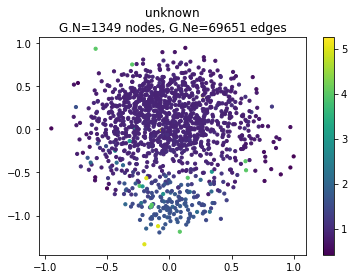

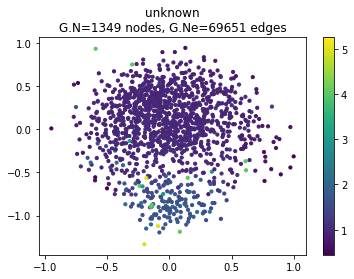

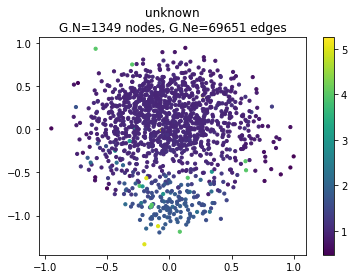

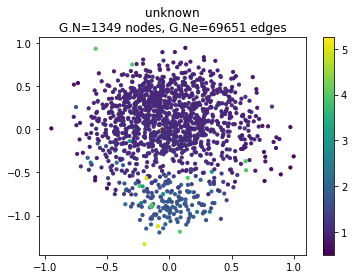

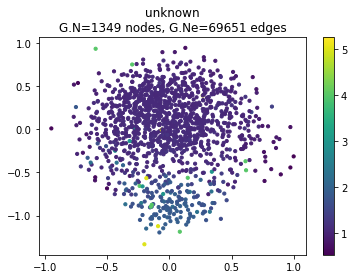

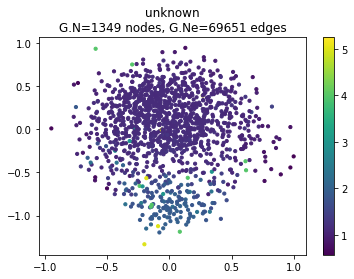

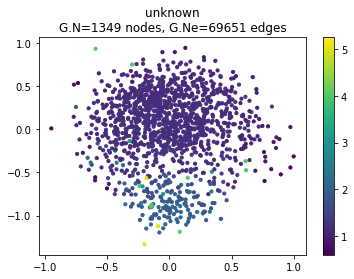

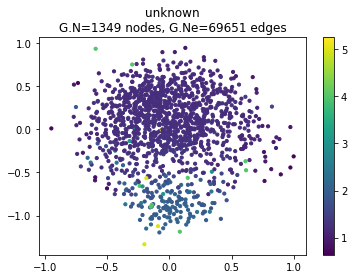

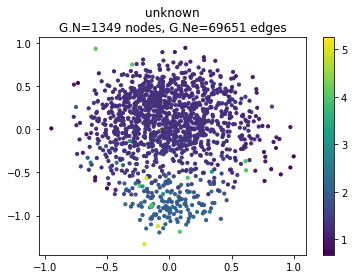

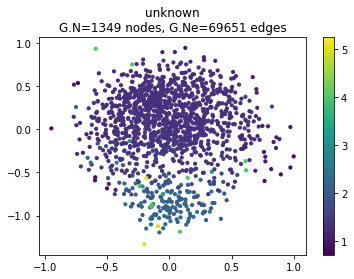

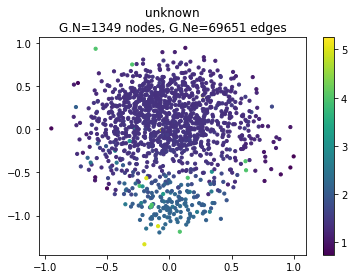

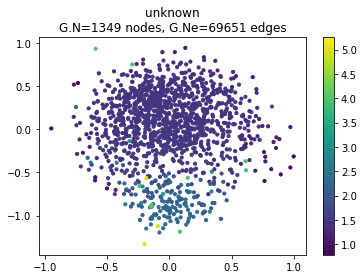

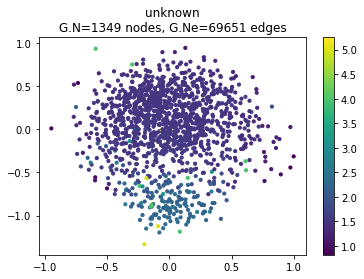

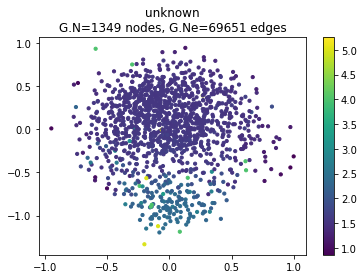

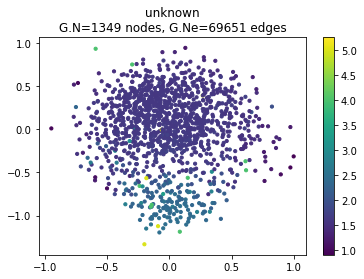

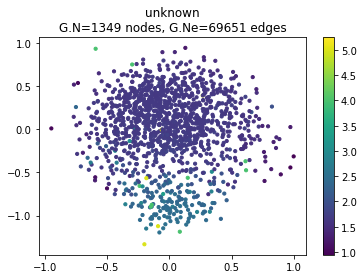

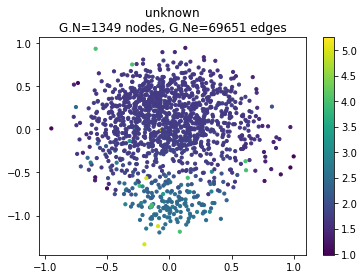

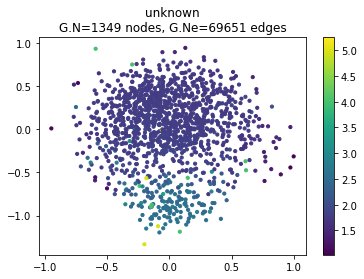

In [206]:
#s = g.filter(signal, method='chebyshev')
s = iterfilter(signal, g, 50)

IndexError: too many indices for array

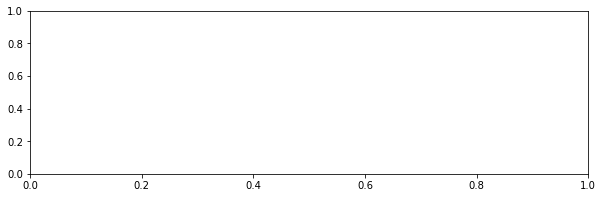

In [190]:
fig = plt.figure(figsize=(10, 3))
for i in range(g.Nf):
    ax = fig.add_subplot(1, g.Nf, i+1)
    G.plot_signal(s[:, i], vertex_size = 10, ax=ax)
    title = r'Heat diffusion, $\tau={}$'.format(taus[i])
    _ = ax.set_title(title)
    ax.set_axis_off()
fig.tight_layout()

In [178]:
def rescale(a, b, signal):
    return a + ((signal - np.min(signal))*(b-a))/(np.max(signal) - np.min(signal))

In [217]:
def get_recommendations(signal, s, n_recommendations, n_user):
    indices = ((ratings != 0).sum(axis = 0) >= 5)
    unrated_indices = (signal == 0)
    s[unrated_indices]
    ratings_user = data[n_user]
    ratings_user[indices] = signal
    sorted_indices = np.argsort(ratings_user, ascending = False)
    sorted_ratings = 
    return sorted_signal[:n_recommendations]

In [218]:
def print_recommendations(recommendation):
    movie_names = movies[recommendation].movie_title
    print(movie_names)

In [ ]:
P[np.argmin(D)]

In [ ]:
print_recommendations(get_recommendations(s, 10, 404))

In [ ]:
np.count_nonzero(adjacency_movies.sum(axis=0) == 0)

In [ ]:
def sub_graph(size, ratings):
    sub_sample = np.random.choice(len(ratings), size=size, replace=False)
    sub_ratings = ratings[sub_sample,sub_sample]
    return sub_ratings

In [ ]:
from pygsp import graphs, plotting
sub = sub_graph(200, adjacency_movies)
G = graphs.Graph(sub)

G.compute_fourier_basis()
label_signal = np.copysign(np.ones(G.N), G.U[:, 3])
G.set_coordinates(kind = 'random2D')
G.plot_signal(label_signal)

In [ ]:
adjacency_movies = (0.4 * jaccard_similarity_movies + 0.5 * euclidean_distance_matrix_movies * 0.2 + 0.1 * common_movies)
adjacency_movies = (1 - adjacency_movies - np.eye(adjacency_movies.shape[0])) * (adjacency_movies < 0.5)

In [ ]:
adjacency_users = (jaccard_similarity_users + euclidean_distance_matrix_users * 0.2) / 2
adjacency_users = (1 - adjacency_users - np.eye(adjacency_users.shape[0])) * (adjacency_users < 0.52)

In [ ]:
adjacency_movies.sum(axis = 0).mean()

In [ ]:
plt.spy(adjacency_movies)
plt.show()

In [ ]:
plt.spy(adjacency_users)
plt.show()

In [ ]:
G = nx.from_numpy_matrix(adjacency_movies)

In [ ]:
G2 = nx.from_numpy_matrix(adjacency_users)

In [ ]:
nx.number_connected_components(G)

In [ ]:
G.degree()

In [ ]:
nx.drawing.nx_pylab.draw(G)

In [ ]:
nx.write_gexf(G, 'Data/adjacency_movies.gexf')

In [ ]:
nx.write_gexf(G2, 'Data/adjacency_users.gexf')

In [ ]:
df = pd.DataFrame(adjacency_movies)

In [ ]:
df.to_csv("Data/adjacency_movies.csv", index = False, header = False)

In [ ]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(G)
plt.axis('off')

plt.show()